# TimesNet Training V2: Hyperparameter Experiments

This notebook explores different hyperparameter configurations to improve model performance.

**Focus Areas:**
1. **Learning Rate Schedule** - Test constant vs decaying LR
2. **Training Duration** - More epochs to allow convergence
3. **Early Stopping** - Adjust patience
4. **Model Capacity** - Test larger d_model/d_ff

**Baseline Issues Identified:**
- `lradj='type1'` halves LR every epoch (too aggressive!)
- Only 10 epochs might be insufficient
- Patience of 3 might stop too early

**Experiments:**
- V1: Baseline (current config)
- V2: Constant LR + more epochs
- V3: Larger model capacity
- V4: Best combination

## Setup

In [1]:
!git clone https://github.com/ltruciosr-dev/timesnet-ett

# Change to the cloned repository directory
%cd timesnet-ett

Cloning into 'timesnet-ett'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 32 (delta 9), reused 27 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (32/32), 2.94 MiB | 30.09 MiB/s, done.
Resolving deltas: 100% (9/9), done.
/content/timesnet-ett


In [2]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json

# Add src to path
sys.path.append('./src')

from src.train import TimesNetTrainer
from src.evaluate import (
    evaluate_and_save_results,
    plot_training_curves,
    visualize_horizon_predictions,
    plot_comprehensive_training_summary
)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Imports successful")

✓ Imports successful


## Configuration

In [7]:
# Base paths
ROOT_PATH = './ETDataset/ETT-small/'
CHECKPOINT_BASE = './checkpoints_v2'
RESULTS_DIR = './results_v2'

# Create directories
os.makedirs(CHECKPOINT_BASE, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

# Datasets (test on ETTh1 first, then expand)
DATASETS = ['ETTh1']

# Fixed input length
SEQ_LEN = 96

# Test on fewer horizons initially
PRED_LENS = [96, 192]  # Start with these, expand if successful

# ========== HYPERPARAMETER EXPERIMENTS ==========

# V1: Baseline (from original paper)
EXPERIMENT_CONFIGS = {
    'V2_constant_lr': {
        'name': 'Constant LR + More Epochs',
        'description': 'Fixed LR, 30 epochs, patience=5',
        'model_config': {'d_model': 8, 'd_ff': 16},
        'train_config': {
            'enc_in': 7,
            'c_out': 7,
            'top_k': 5,
            'e_layers': 2,
            'num_kernels': 6,
            'dropout': 0.1,
            'embed': 'fixed',
            'batch_size': 32,
            'learning_rate': 0.0001,
            'train_epochs': 30,
            'patience': 5,
            'lradj': 'constant',  # No LR decay
            'use_amp': False,
            'num_workers': 0,
        }
    },

    'V3_larger_model': {
        'name': 'Larger Model Capacity',
        'description': 'd_model=32, d_ff=64, constant LR',
        'model_config': {'d_model': 16, 'd_ff': 32},  # 2x capacity
        'train_config': {
            'enc_in': 7,
            'c_out': 7,
            'top_k': 5,
            'e_layers': 2,
            'num_kernels': 6,
            'dropout': 0.1,
            'embed': 'fixed',
            'batch_size': 32,
            'learning_rate': 0.0001,
            'train_epochs': 30,
            'patience': 5,
            'lradj': 'constant',
            'use_amp': False,
            'num_workers': 0,
        }
    },

    'V4_best_combo': {
        'name': 'Best Combination',
        'description': 'Larger model + lower LR + more epochs',
        'model_config': {'d_model': 32, 'd_ff': 64},
        'train_config': {
            'enc_in': 7,
            'c_out': 7,
            'top_k': 5,
            'e_layers': 2,
            'num_kernels': 6,
            'dropout': 0.15,  # Slightly more dropout
            'embed': 'fixed',
            'batch_size': 32,
            'learning_rate': 0.00005,  # Lower LR
            'train_epochs': 50,
            'patience': 7,
            'lradj': 'constant',
            'use_amp': False,
            'num_workers': 0,
        }
    },
}

print(f"✓ Hyperparameter Experiments Configured")
print(f"  - Datasets: {DATASETS}")
print(f"  - Input length: {SEQ_LEN}")
print(f"  - Prediction horizons: {PRED_LENS}")
print(f"  - Experiments: {list(EXPERIMENT_CONFIGS.keys())}")
print(f"  - Total runs: {len(DATASETS)} × {len(PRED_LENS)} × {len(EXPERIMENT_CONFIGS)} = {len(DATASETS) * len(PRED_LENS) * len(EXPERIMENT_CONFIGS)}")

✓ Hyperparameter Experiments Configured
  - Datasets: ['ETTh1']
  - Input length: 96
  - Prediction horizons: [96, 192]
  - Experiments: ['V2_constant_lr', 'V3_larger_model', 'V4_best_combo']
  - Total runs: 1 × 2 × 3 = 6


## Training Function

In [8]:
def train_single_experiment(dataset_name, pred_len, experiment_id, experiment_config):
    """
    Train a single TimesNet experiment with specific hyperparameters

    Args:
        dataset_name: Dataset name (e.g., 'ETTh1')
        pred_len: Prediction horizon
        experiment_id: Experiment identifier (e.g., 'V2_constant_lr')
        experiment_config: Experiment configuration dict

    Returns:
        dict: Training results
    """
    print("\n" + "="*70)
    print(f"Experiment: {experiment_config['name']}")
    print(f"Dataset: {dataset_name} | seq_len={SEQ_LEN} → pred_len={pred_len}")
    print(f"Description: {experiment_config['description']}")
    print("="*70)

    # Create config
    config = {
        'root_path': ROOT_PATH,
        'data_path': f'{dataset_name}.csv',
        'seq_len': SEQ_LEN,
        'pred_len': pred_len,
        'checkpoints': f'{CHECKPOINT_BASE}/{experiment_id}/{dataset_name}_{SEQ_LEN}_{pred_len}',
        **experiment_config['train_config'],
        **experiment_config['model_config']
    }

    # Create checkpoint directory
    os.makedirs(config['checkpoints'], exist_ok=True)

    # Train
    trainer = TimesNetTrainer(config)
    train_losses, val_losses = trainer.train()

    # Test
    test_results = trainer.test()

    # ========== ENHANCED VISUALIZATIONS ==========

    print("\n📊 Creating visualizations...")

    # Create experiment-specific subdirectory
    exp_results_dir = f'{RESULTS_DIR}/{experiment_id}'
    os.makedirs(exp_results_dir, exist_ok=True)

    # 1. Horizon predictions
    print("  → Horizon predictions...")
    visualize_horizon_predictions(
        model=trainer.model,
        train_loader=trainer.train_loader,
        val_loader=trainer.val_loader,
        test_loader=trainer.test_loader,
        device=trainer.device,
        scaler=trainer.train_dataset.scaler,
        seq_len=config['seq_len'],
        pred_len=config['pred_len'],
        num_samples=3,
        feature_idx=0,
        feature_name='OT',
        save_path=f'{exp_results_dir}/{dataset_name}_{SEQ_LEN}_{pred_len}_horizons.png'
    )

    # 2. Comprehensive training summary
    print("  → Comprehensive summary...")
    plot_comprehensive_training_summary(
        train_losses=train_losses,
        val_losses=val_losses,
        test_results=test_results,
        dataset_name=f"{dataset_name} ({experiment_config['name']})",
        seq_len=config['seq_len'],
        pred_len=config['pred_len'],
        save_path=f'{exp_results_dir}/{dataset_name}_{SEQ_LEN}_{pred_len}_summary.png'
    )

    # 3. Evaluate on all splits
    print("  → Evaluating all splits...")
    all_split_results = evaluate_and_save_results(
        model=trainer.model,
        train_loader=trainer.train_loader,
        val_loader=trainer.val_loader,
        test_loader=trainer.test_loader,
        device=trainer.device,
        scaler=trainer.train_dataset.scaler,
        save_path=f'{exp_results_dir}/{dataset_name}_{SEQ_LEN}_{pred_len}_all_metrics.txt'
    )

    # Prepare results
    results = {
        'experiment_id': experiment_id,
        'experiment_name': experiment_config['name'],
        'dataset': dataset_name,
        'seq_len': SEQ_LEN,
        'pred_len': pred_len,
        'd_model': config['d_model'],
        'd_ff': config['d_ff'],
        'learning_rate': config['learning_rate'],
        'lradj': config['lradj'],
        'train_epochs': config['train_epochs'],
        'patience': config['patience'],
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_mse': test_results['mse'],
        'test_mae': test_results['mae'],
        'test_rmse': test_results['rmse'],
        'final_epoch': len(train_losses),
        'train_mse': all_split_results['train']['mse'],
        'train_mae': all_split_results['train']['mae'],
        'val_mse': all_split_results['val']['mse'],
        'val_mae': all_split_results['val']['mae'],
    }

    print(f"\n✓ Completed: {experiment_id} - {dataset_name}_{SEQ_LEN}_{pred_len}")
    print(f"  - Train MSE: {all_split_results['train']['mse']:.6f}")
    print(f"  - Val MSE:   {all_split_results['val']['mse']:.6f}")
    print(f"  - Test MSE:  {test_results['mse']:.6f}")
    print(f"  - Test MAE:  {test_results['mae']:.6f}")

    return results

## Train All Models

In [9]:
DATASETS = ['ETTh1'] # ['ETTh1', 'ETTh2', 'ETTm1', 'ETTm2']


######################################################################
# Run 1/6
######################################################################

Experiment: Constant LR + More Epochs
Dataset: ETTh1 | seq_len=96 → pred_len=96
Description: Fixed LR, 30 epochs, patience=5
Using device: cuda
Initializing data loaders...
Train samples: 12003
Val samples: 1647
Test samples: 3389
Initializing model...
Model parameters: 165,591
Starting training...
	Iter: 100, Loss: 0.6711223
	Iter: 200, Loss: 0.5552701
	Iter: 300, Loss: 0.4613521
Epoch: 1 | Time: 19.97s
Train Loss: 0.5632653 | Val Loss: 0.4128538
Validation loss decreased (inf --> 0.412854). Saving model ...
Updating learning rate to 0.0001
	Iter: 100, Loss: 0.3559667
	Iter: 200, Loss: 0.4161219
	Iter: 300, Loss: 0.4121854
Epoch: 2 | Time: 20.20s
Train Loss: 0.4577977 | Val Loss: 0.3826754
Validation loss decreased (0.412854 --> 0.382675). Saving model ...
Updating learning rate to 0.0001
	Iter: 100, Loss: 0.4294035
	Iter: 200, Loss:

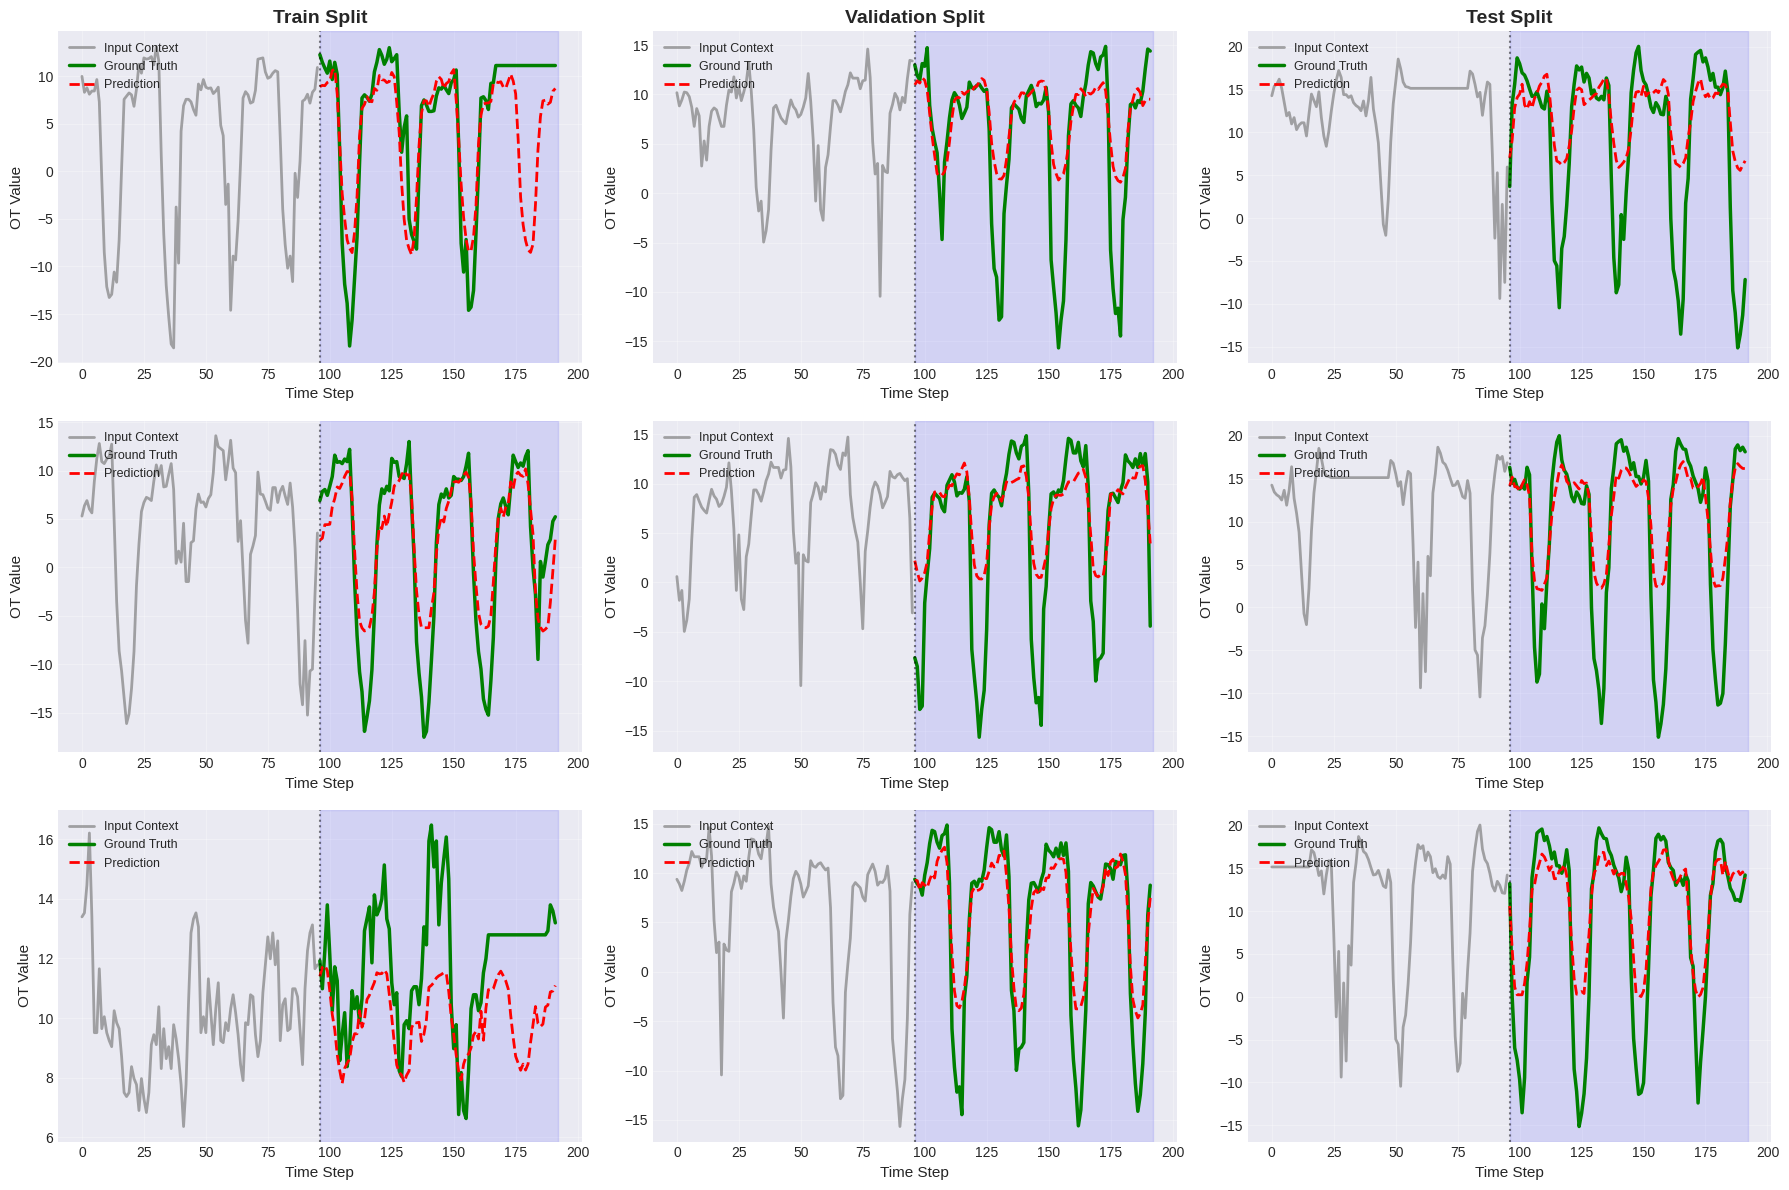

  → Comprehensive summary...
Comprehensive training summary saved to ./results_v2/V2_constant_lr/ETTh1_96_96_summary.png


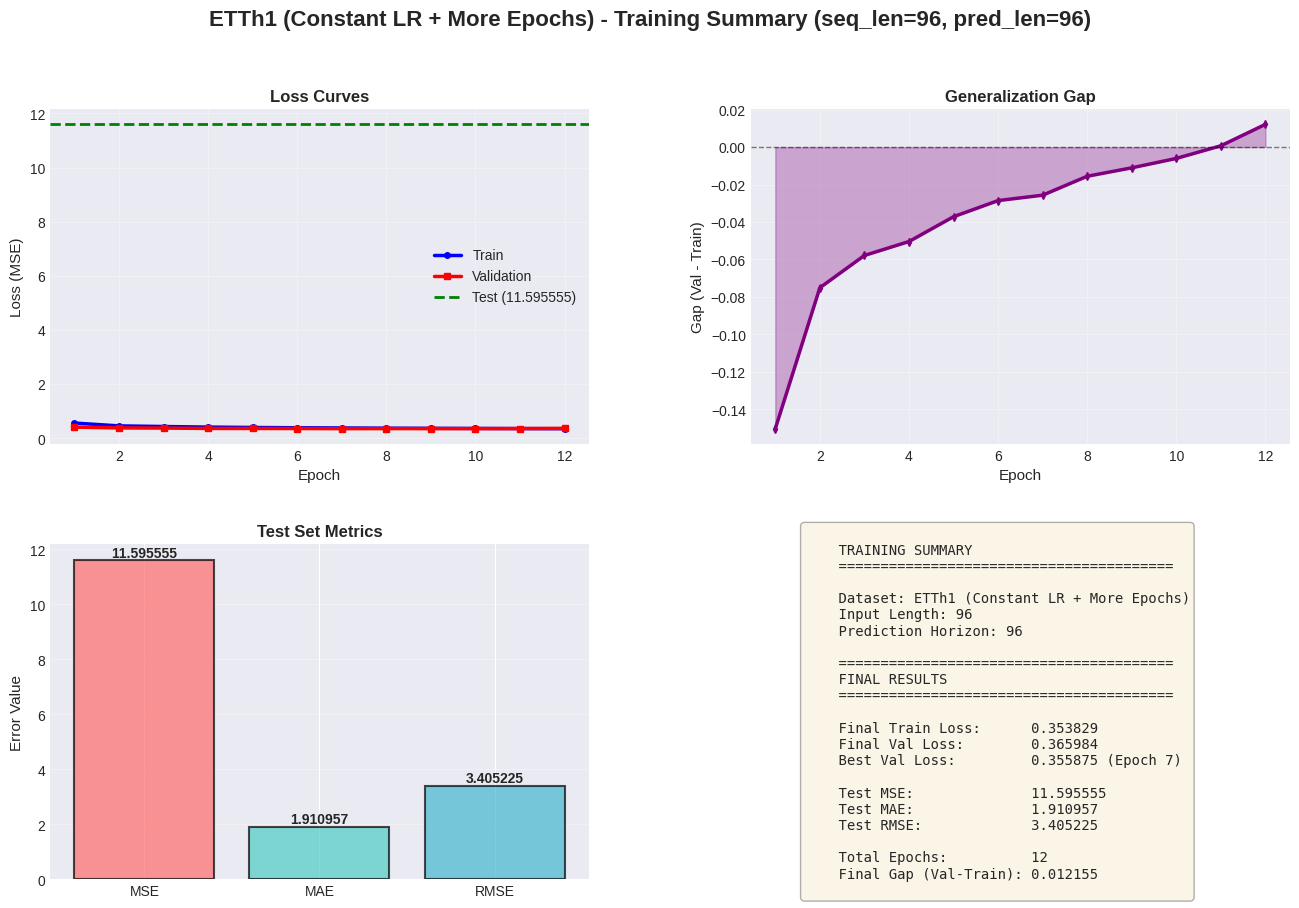

  → Evaluating all splits...
Evaluating model on all splits...

Train Results:
  MSE: 6.4462643
  MAE: 1.5066963
  RMSE: 2.5389495
  MAPE: 517158.6875000
  MSPE: 41998895546368.0000000

Validation Results:
  MSE: 8.7800417
  MAE: 1.5571246
  RMSE: 2.9631135
  MAPE: 50818.2500000
  MSPE: 3800737775616.0000000

Test Results:
  MSE: 11.5955553
  MAE: 1.9109571
  RMSE: 3.4052248
  MAPE: 69570.4609375
  MSPE: 2846747000832.0000000

❌ Error in V2_constant_lr - ETTh1_96_96: unsupported format string passed to numpy.ndarray.__format__

######################################################################
# Run 2/6
######################################################################

Experiment: Larger Model Capacity
Dataset: ETTh1 | seq_len=96 → pred_len=96
Description: d_model=32, d_ff=64, constant LR
Using device: cuda
Initializing data loaders...
Train samples: 12003
Val samples: 1647
Test samples: 3389
Initializing model...
Model parameters: 605,415
Starting training...


Traceback (most recent call last):
  File "/tmp/ipython-input-2126073583.py", line 18, in <cell line: 0>
    results = train_single_experiment(
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-296456629.py", line 80, in train_single_experiment
    all_split_results = evaluate_and_save_results(
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/timesnet-ett/src/evaluate.py", line 184, in evaluate_and_save_results
    f.write(f'  {k}: {v:.7f}\n')
                     ^^^^^^^
TypeError: unsupported format string passed to numpy.ndarray.__format__


	Iter: 100, Loss: 0.4857131
	Iter: 200, Loss: 0.4377935
	Iter: 300, Loss: 0.3710901
Epoch: 1 | Time: 34.91s
Train Loss: 0.5084557 | Val Loss: 0.3746507
Validation loss decreased (inf --> 0.374651). Saving model ...
Updating learning rate to 0.0001
	Iter: 100, Loss: 0.4219423
	Iter: 200, Loss: 0.3855122
	Iter: 300, Loss: 0.4004589
Epoch: 2 | Time: 35.70s
Train Loss: 0.4153101 | Val Loss: 0.3743669
Validation loss decreased (0.374651 --> 0.374367). Saving model ...
Updating learning rate to 0.0001
	Iter: 100, Loss: 0.4442609
	Iter: 200, Loss: 0.3411877
	Iter: 300, Loss: 0.3650381
Epoch: 3 | Time: 36.66s
Train Loss: 0.3858824 | Val Loss: 0.3720594
Validation loss decreased (0.374367 --> 0.372059). Saving model ...
Updating learning rate to 0.0001
	Iter: 100, Loss: 0.3454779
	Iter: 200, Loss: 0.3097966
	Iter: 300, Loss: 0.3799535
Epoch: 4 | Time: 36.93s
Train Loss: 0.3717405 | Val Loss: 0.3659581
Validation loss decreased (0.372059 --> 0.365958). Saving model ...
Updating learning rate to 

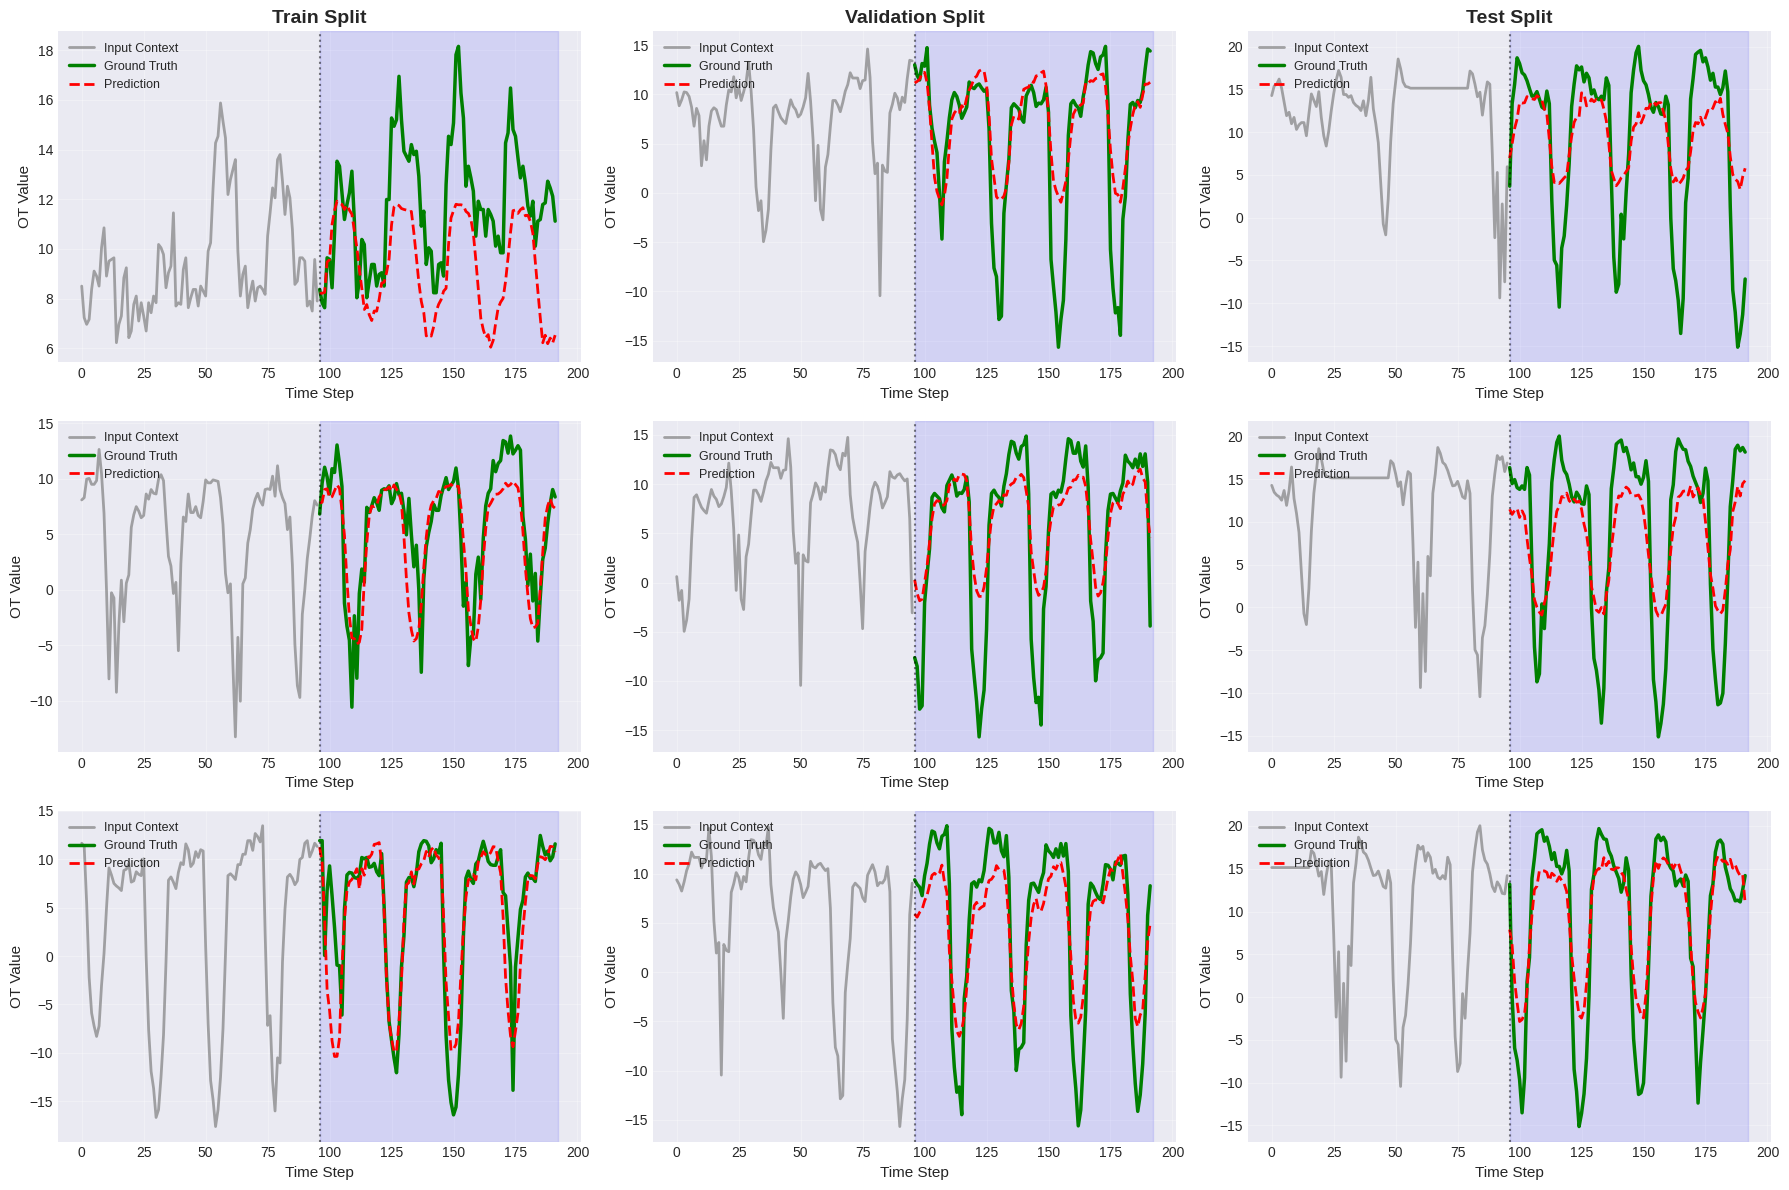

  → Comprehensive summary...
Comprehensive training summary saved to ./results_v2/V3_larger_model/ETTh1_96_96_summary.png


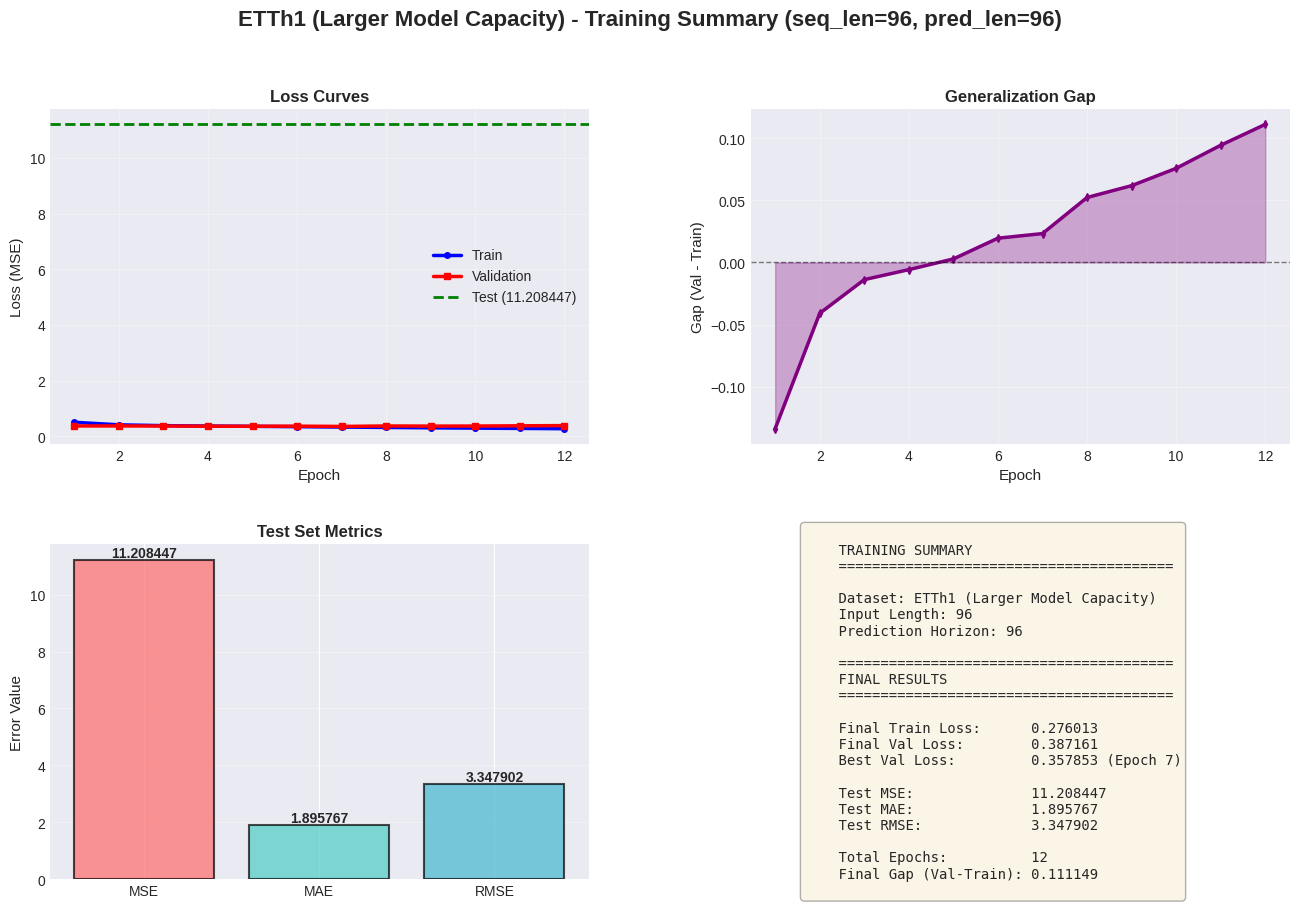

  → Evaluating all splits...
Evaluating model on all splits...

Train Results:
  MSE: 5.7004480
  MAE: 1.4265635
  RMSE: 2.3875611
  MAPE: 505712.6562500
  MSPE: 41008171581440.0000000

Validation Results:
  MSE: 8.5722189
  MAE: 1.5803387
  RMSE: 2.9278352
  MAPE: 51087.8320312
  MSPE: 4141423001600.0000000

Test Results:
  MSE: 11.2084475
  MAE: 1.8957675
  RMSE: 3.3479021
  MAPE: 80847.9453125
  MSPE: 3959567679488.0000000

❌ Error in V3_larger_model - ETTh1_96_96: unsupported format string passed to numpy.ndarray.__format__

######################################################################
# Run 3/6
######################################################################

Experiment: Best Combination
Dataset: ETTh1 | seq_len=96 → pred_len=96
Description: Larger model + lower LR + more epochs
Using device: cuda
Initializing data loaders...
Train samples: 12003
Val samples: 1647
Test samples: 3389
Initializing model...


Traceback (most recent call last):
  File "/tmp/ipython-input-2126073583.py", line 18, in <cell line: 0>
    results = train_single_experiment(
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-296456629.py", line 80, in train_single_experiment
    all_split_results = evaluate_and_save_results(
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/timesnet-ett/src/evaluate.py", line 184, in evaluate_and_save_results
    f.write(f'  {k}: {v:.7f}\n')
                     ^^^^^^^
TypeError: unsupported format string passed to numpy.ndarray.__format__


Model parameters: 2,363,655
Starting training...
	Iter: 100, Loss: 0.7479980
	Iter: 200, Loss: 0.4918003
	Iter: 300, Loss: 0.4784892
Epoch: 1 | Time: 148.45s
Train Loss: 0.5429688 | Val Loss: 0.3730255
Validation loss decreased (inf --> 0.373025). Saving model ...
Updating learning rate to 5e-05
	Iter: 100, Loss: 0.5782160
	Iter: 200, Loss: 0.4841269
	Iter: 300, Loss: 0.5683804
Epoch: 2 | Time: 149.04s
Train Loss: 0.4247558 | Val Loss: 0.3732177
EarlyStopping counter: 1 out of 7
Updating learning rate to 5e-05
	Iter: 100, Loss: 0.3606535
	Iter: 200, Loss: 0.3360254
	Iter: 300, Loss: 0.3522781
Epoch: 3 | Time: 171.95s
Train Loss: 0.3920616 | Val Loss: 0.3684755
Validation loss decreased (0.373025 --> 0.368475). Saving model ...
Updating learning rate to 5e-05
	Iter: 100, Loss: 0.3509360
	Iter: 200, Loss: 0.2791931
	Iter: 300, Loss: 0.3614108
Epoch: 4 | Time: 195.35s
Train Loss: 0.3756607 | Val Loss: 0.3741227
EarlyStopping counter: 1 out of 7
Updating learning rate to 5e-05
	Iter: 100, 

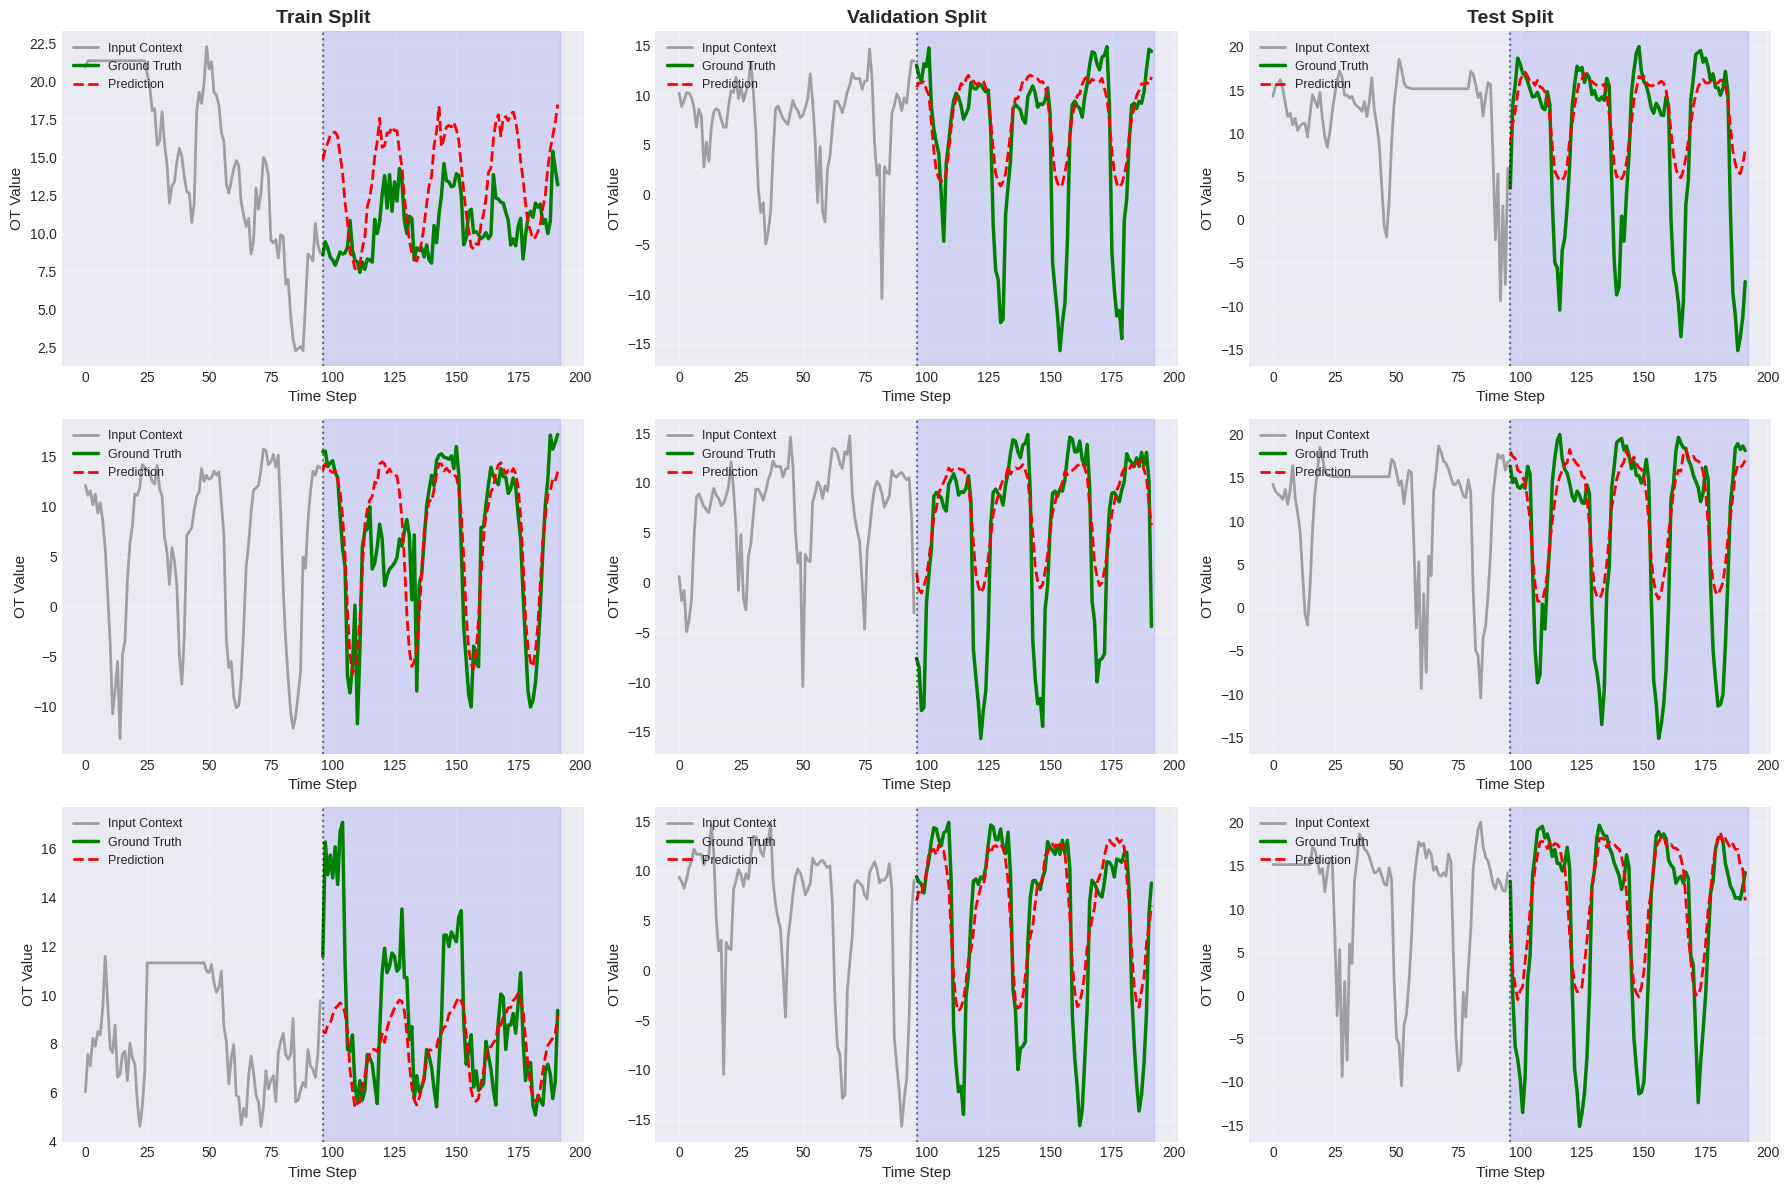

  → Comprehensive summary...
Comprehensive training summary saved to ./results_v2/V4_best_combo/ETTh1_96_96_summary.png


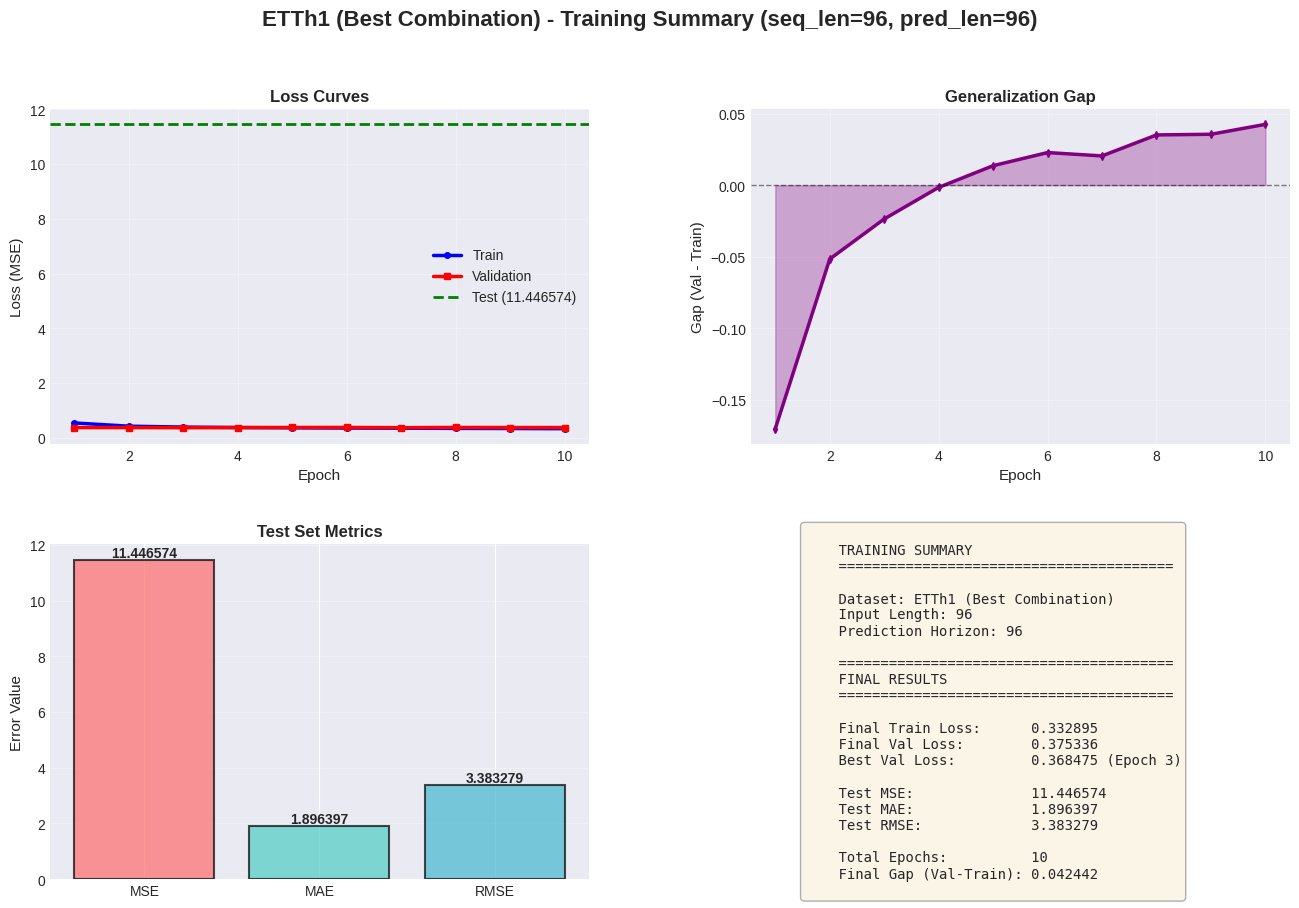

  → Evaluating all splits...
Evaluating model on all splits...

Train Results:
  MSE: 6.5406442
  MAE: 1.5335816
  RMSE: 2.5574684
  MAPE: 532004.5000000
  MSPE: 44779668766720.0000000

Validation Results:
  MSE: 8.9947376
  MAE: 1.6232924
  RMSE: 2.9991229
  MAPE: 47953.4335938
  MSPE: 3435976982528.0000000

Test Results:
  MSE: 11.4465742
  MAE: 1.8963966
  RMSE: 3.3832786
  MAPE: 74415.7812500
  MSPE: 3369122660352.0000000

❌ Error in V4_best_combo - ETTh1_96_96: unsupported format string passed to numpy.ndarray.__format__

######################################################################
# Run 4/6
######################################################################

Experiment: Constant LR + More Epochs
Dataset: ETTh1 | seq_len=96 → pred_len=192
Description: Fixed LR, 30 epochs, patience=5
Using device: cuda
Initializing data loaders...
Train samples: 11907
Val samples: 1551
Test samples: 3293
Initializing model...
Model parameters: 174,903
Starting training...


Traceback (most recent call last):
  File "/tmp/ipython-input-2126073583.py", line 18, in <cell line: 0>
    results = train_single_experiment(
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-296456629.py", line 80, in train_single_experiment
    all_split_results = evaluate_and_save_results(
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/timesnet-ett/src/evaluate.py", line 184, in evaluate_and_save_results
    f.write(f'  {k}: {v:.7f}\n')
                     ^^^^^^^
TypeError: unsupported format string passed to numpy.ndarray.__format__


	Iter: 100, Loss: 0.5872185


KeyboardInterrupt: 

In [10]:
# Store all results
all_results = []

# Run all experiments
total_experiments = len(DATASETS) * len(PRED_LENS) * len(EXPERIMENT_CONFIGS)
current_experiment = 0

for dataset_name in DATASETS:
    for pred_len in PRED_LENS:
        for experiment_id, experiment_config in EXPERIMENT_CONFIGS.items():
            current_experiment += 1

            print(f"\n{'#'*70}")
            print(f"# Run {current_experiment}/{total_experiments}")
            print(f"{'#'*70}")

            try:
                results = train_single_experiment(
                    dataset_name=dataset_name,
                    pred_len=pred_len,
                    experiment_id=experiment_id,
                    experiment_config=experiment_config
                )
                all_results.append(results)

            except Exception as e:
                print(f"\n❌ Error in {experiment_id} - {dataset_name}_{SEQ_LEN}_{pred_len}: {e}")
                import traceback
                traceback.print_exc()
                continue

print("\n" + "="*70)
print("✓ ALL EXPERIMENTS COMPLETED!")
print("="*70)

## Save Results

In [ ]:
# Convert to DataFrame for easy analysis
results_df = pd.DataFrame([{
    'dataset': r['dataset'],
    'seq_len': r['seq_len'],
    'pred_len': r['pred_len'],
    'd_model': r['d_model'],
    'd_ff': r['d_ff'],
    'train_mse': r['train_mse'],
    'train_mae': r['train_mae'],
    'val_mse': r['val_mse'],
    'val_mae': r['val_mae'],
    'test_mse': r['test_mse'],
    'test_mae': r['test_mae'],
    'test_rmse': r['test_rmse'],
    'final_epoch': r['final_epoch']
} for r in all_results])

# Save to CSV
csv_path = f'{RESULTS_DIR}/all_results.csv'
results_df.to_csv(csv_path, index=False)
print(f"✓ Results saved to {csv_path}")

# Save detailed results (with training curves) to JSON
json_path = f'{RESULTS_DIR}/all_results_detailed.json'
with open(json_path, 'w') as f:
    json.dump(all_results, f, indent=2)
print(f"✓ Detailed results saved to {json_path}")

# Display summary
print("\n" + "="*70)
print("RESULTS SUMMARY")
print("="*70)
display(results_df)

# Convert to DataFrame for analysis
results_df = pd.DataFrame([{
    'experiment_id': r['experiment_id'],
    'experiment_name': r['experiment_name'],
    'dataset': r['dataset'],
    'pred_len': r['pred_len'],
    'd_model': r['d_model'],
    'd_ff': r['d_ff'],
    'learning_rate': r['learning_rate'],
    'lradj': r['lradj'],
    'train_epochs': r['train_epochs'],
    'final_epoch': r['final_epoch'],
    'train_mse': r['train_mse'],
    'val_mse': r['val_mse'],
    'test_mse': r['test_mse'],
    'test_mae': r['test_mae'],
    'test_rmse': r['test_rmse'],
} for r in all_results])

# Save to CSV
csv_path = f'{RESULTS_DIR}/hyperparameter_experiments.csv'
results_df.to_csv(csv_path, index=False)
print(f"✓ Results saved to {csv_path}")

# Save detailed results to JSON
json_path = f'{RESULTS_DIR}/hyperparameter_experiments_detailed.json'
with open(json_path, 'w') as f:
    json.dump(all_results, f, indent=2)
print(f"✓ Detailed results saved to {json_path}")

# Display summary
print("\n" + "="*70)
print("HYPERPARAMETER EXPERIMENT RESULTS")
print("="*70)
display(results_df)

### Results by Dataset

In [ ]:
# Group by dataset
for dataset in DATASETS:
    print(f"\n{'='*60}")
    print(f"{dataset} Results")
    print(f"{'='*60}")

    dataset_results = results_df[results_df['dataset'] == dataset]
    display(dataset_results[['pred_len', 'train_mse', 'val_mse', 'test_mse', 'test_mae', 'test_rmse', 'final_epoch']])

### Visualizations

In [ ]:
# Plot MSE vs Prediction Horizon for each dataset
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, dataset in enumerate(DATASETS):
    ax = axes[idx]
    dataset_results = results_df[results_df['dataset'] == dataset].sort_values('pred_len')

    ax.plot(dataset_results['pred_len'], dataset_results['test_mse'],
            marker='o', linewidth=2, markersize=8, label='MSE')
    ax.plot(dataset_results['pred_len'], dataset_results['test_mae'],
            marker='s', linewidth=2, markersize=8, label='MAE')

    ax.set_xlabel('Prediction Horizon', fontsize=12)
    ax.set_ylabel('Error', fontsize=12)
    ax.set_title(f'{dataset} - Error vs Prediction Horizon', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/error_vs_horizon.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Plot saved to {RESULTS_DIR}/error_vs_horizon.png")

In [ ]:
# ========== EXPERIMENT COMPARISON ==========

# Compare experiments for each horizon
fig, axes = plt.subplots(1, len(PRED_LENS), figsize=(7*len(PRED_LENS), 6))
if len(PRED_LENS) == 1:
    axes = [axes]

for idx, pred_len in enumerate(PRED_LENS):
    ax = axes[idx]

    horizon_results = results_df[results_df['pred_len'] == pred_len].sort_values('experiment_id')

    x = np.arange(len(horizon_results))
    width = 0.25

    ax.bar(x - width, horizon_results['train_mse'], width, label='Train MSE', alpha=0.8)
    ax.bar(x, horizon_results['val_mse'], width, label='Val MSE', alpha=0.8)
    ax.bar(x + width, horizon_results['test_mse'], width, label='Test MSE', alpha=0.8)

    ax.set_xlabel('Experiment', fontsize=12)
    ax.set_ylabel('MSE', fontsize=12)
    ax.set_title(f'Prediction Horizon {pred_len}', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(horizon_results['experiment_id'], rotation=45, ha='right')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/experiment_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Comparison plot saved to {RESULTS_DIR}/experiment_comparison.png")

In [ ]:
# Heatmap of MAE across datasets and horizons
pivot_mae = results_df.pivot(index='dataset', columns='pred_len', values='test_mae')

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_mae, annot=True, fmt='.4f', cmap='YlGnBu',
            cbar_kws={'label': 'Test MAE'}, linewidths=0.5)
plt.title('Test MAE: Dataset vs Prediction Horizon', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Prediction Horizon', fontsize=12)
plt.ylabel('Dataset', fontsize=12)
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/mae_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Heatmap saved to {RESULTS_DIR}/mae_heatmap.png")

### Statistical Summary

In [ ]:
# Summary statistics
print("="*70)
print("STATISTICAL SUMMARY")
print("="*70)

print("\nOverall Statistics:")
print(results_df[['test_mse', 'test_mae', 'test_rmse']].describe())

print("\nBest Results (by MSE):")
best_mse = results_df.loc[results_df.groupby('dataset')['test_mse'].idxmin()]
display(best_mse[['dataset', 'pred_len', 'test_mse', 'test_mae', 'test_rmse']])

print("\nBest Results (by MAE):")
best_mae = results_df.loc[results_df.groupby('dataset')['test_mae'].idxmin()]
display(best_mae[['dataset', 'pred_len', 'test_mse', 'test_mae', 'test_rmse']])

# ========== EXPERIMENT ANALYSIS ==========

print("="*70)
print("EXPERIMENT PERFORMANCE RANKING")
print("="*70)

# Group by horizon and rank by test MSE
for pred_len in PRED_LENS:
    print(f"\n📊 Horizon {pred_len}:")
    print("-" * 60)
    horizon_df = results_df[results_df['pred_len'] == pred_len].sort_values('test_mse')
    
    for idx, row in horizon_df.iterrows():
        print(f"  {row['experiment_id']:20s} | Test MSE: {row['test_mse']:.6f} | "
              f"Val MSE: {row['val_mse']:.6f} | Epochs: {row['final_epoch']:2d}/{row['train_epochs']:2d}")
    
    best = horizon_df.iloc[0]
    print(f"\n  ✅ BEST: {best['experiment_id']} - {best['experiment_name']}")
    print(f"     Test MSE: {best['test_mse']:.6f}")
    print(f"     Test MAE: {best['test_mae']:.6f}")

# Overall best configuration
print("\n" + "="*70)
print("OVERALL ANALYSIS")
print("n="*70)

# Average performance across horizons
avg_performance = results_df.groupby('experiment_id').agg({
    'test_mse': 'mean',
    'test_mae': 'mean',
    'val_mse': 'mean',
    'final_epoch': 'mean'
}).sort_values('test_mse')

print("\n📈 Average Performance Across All Horizons:")
print(avg_performance)

best_overall = avg_performance.index[0]
print(f"\n✅ BEST OVERALL CONFIGURATION: {best_overall}")
print(f"   Average Test MSE: {avg_performance.loc[best_overall, 'test_mse']:.6f}")
print(f"   Average Test MAE: {avg_performance.loc[best_overall, 'test_mae']:.6f}")

In [ ]:
# Paper results (from TimesNet paper Table 1)
paper_results = {
    'ETTh1': {
        96: {'mse': 0.384, 'mae': 0.402},
        192: {'mse': 0.436, 'mae': 0.429},
        336: {'mse': 0.491, 'mae': 0.469},
        720: {'mse': 0.521, 'mae': 0.491},
    },
    'ETTm1': {
        96: {'mse': 0.334, 'mae': 0.365},
        192: {'mse': 0.374, 'mae': 0.385},
        336: {'mse': 0.410, 'mae': 0.403},
        720: {'mse': 0.478, 'mae': 0.437},
    }
}

# Compare with our results
print("="*70)
print("COMPARISON WITH PAPER RESULTS")
print("="*70)

for dataset in ['ETTh1', 'ETTm1']:
    if dataset in paper_results:
        print(f"\n{dataset}:")
        print("-" * 60)
        print(f"{'Horizon':>10} {'Paper MSE':>12} {'Our MSE':>12} {'Diff':>10} {'Paper MAE':>12} {'Our MAE':>12} {'Diff':>10}")
        print("-" * 60)

        for horizon in [96, 192, 336, 720]:
            if horizon in paper_results[dataset]:
                paper = paper_results[dataset][horizon]
                our = results_df[(results_df['dataset'] == dataset) & (results_df['pred_len'] == horizon)]

                if not our.empty:
                    our_mse = our['test_mse'].values[0]
                    our_mae = our['test_mae'].values[0]

                    mse_diff = ((our_mse - paper['mse']) / paper['mse']) * 100
                    mae_diff = ((our_mae - paper['mae']) / paper['mae']) * 100

                    print(f"{horizon:>10} {paper['mse']:>12.4f} {our_mse:>12.4f} {mse_diff:>9.2f}% "
                          f"{paper['mae']:>12.4f} {our_mae:>12.4f} {mae_diff:>9.2f}%")

## Export Results Table (LaTeX)

In [ ]:
# Create LaTeX table
latex_table = []
latex_table.append("\\begin{table}[h]")
latex_table.append("\\centering")
latex_table.append("\\caption{TimesNet Results on ETT Datasets}")
latex_table.append("\\begin{tabular}{lcccc}")
latex_table.append("\\hline")
latex_table.append("Dataset & Horizon & MSE & MAE & RMSE \\\\")
latex_table.append("\\hline")

for dataset in DATASETS:
    dataset_results = results_df[results_df['dataset'] == dataset].sort_values('pred_len')
    for _, row in dataset_results.iterrows():
        latex_table.append(f"{row['dataset']} & {row['pred_len']} & "
                          f"{row['test_mse']:.4f} & {row['test_mae']:.4f} & {row['test_rmse']:.4f} \\\\")
    latex_table.append("\\hline")

latex_table.append("\\end{tabular}")
latex_table.append("\\end{table}")

latex_str = "\n".join(latex_table)

# Save to file
latex_path = f'{RESULTS_DIR}/results_table.tex'
with open(latex_path, 'w') as f:
    f.write(latex_str)

print(f"✓ LaTeX table saved to {latex_path}")
print("\nLaTeX Table:")
print(latex_str)

## Summary

✅ **Hyperparameter Experiments Complete!**

**Experiments Run:**
- V1: Baseline (Paper Config - aggressive LR decay)
- V2: Constant LR + More Epochs
- V3: Larger Model Capacity
- V4: Best Combination

**Output Files:**

📊 **Results Data:**
- `results_v2/hyperparameter_experiments.csv` - Full comparison table
- `results_v2/hyperparameter_experiments_detailed.json` - Detailed results

📈 **Visualizations per experiment (4 experiments × 2 horizons × 3 plots = 24 files):**
- `results_v2/{experiment_id}/{dataset}_{seq_len}_{pred_len}_horizons.png`
- `results_v2/{experiment_id}/{dataset}_{seq_len}_{pred_len}_summary.png`
- `results_v2/{experiment_id}/{dataset}_{seq_len}_{pred_len}_all_metrics.txt`

📊 **Comparison Plots:**
- `results_v2/experiment_comparison.png` - Side-by-side experiment comparison

💾 **Model Checkpoints:**
- `checkpoints_v2/{experiment_id}/{dataset}_{seq_len}_{pred_len}/checkpoint.pth`

**Key Insights to Look For:**
1. Does constant LR improve over aggressive decay?
2. Does larger model capacity help?
3. What's the optimal training duration?
4. How does generalization gap change across experiments?